# Metropolis Hastings for a probit regression

In [1]:
import numpy as np
from scipy.stats import norm, bernoulli
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

c:\Users\Acer\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [61]:
def probit_posterior(beta, X, Y): #function to compute the posterior based on: Probit likelihood and N(0,1) prior
    eta = np.dot(X, beta)
    mu = norm.cdf(eta)
    log_likelihood = np.sum(Y * np.log(mu) + (1 - Y) * np.log(1 - mu)) - 0.5*np.dot(beta,beta)
    return log_likelihood

def metropolis_hastings_probit_single(Y, X, iterations, proposal_std): #MH single site algorithm
    np.random.seed(80)
    n, p = X.shape
    beta_current = np.zeros(p)
    samples = np.zeros((iterations, p))
    for i in range(iterations):
        for ind in range(p):
            beta_proposal = np.copy(beta_current)
            if ind == p-1: #NOTE: index of the intercept, this is strictly personal to the dataset SAHeart given the different scaling of the intercept
                beta_proposal[ind] = beta_current[ind] + np.random.normal(loc = 0, scale =proposal_std*100)
            else: 
                beta_proposal[ind] = beta_current[ind] + np.random.normal(loc = 0, scale =proposal_std)
            likelihood_current = probit_posterior(beta_current, X, Y)
            likelihood_proposal = probit_posterior(beta_proposal, X, Y)
            log_ratio = likelihood_proposal - likelihood_current
            # Accept or reject the proposal
            if log_ratio > np.log(np.random.uniform(size = 1)):
                beta_current = beta_proposal
            samples[i][ind] = beta_current[ind]
    return samples


def probit_ame(X, b):
    eta = np.dot(X, b)
    pdf = norm.pdf(eta)
    me = pdf[:, np.newaxis] * b
    ame = np.mean(me, axis=0)
    return ame

In [65]:
# def metropolis_hastings_probit(Y, X, iterations, proposal_std): #classic probit regression, not used in this case
#     n, p = X.shape
#     beta_current = np.zeros(p)
#     samples = np.zeros((iterations, p))

#     for i in range(iterations):
#         beta_proposal = beta_current + np.random.normal(loc = 0, scale = proposal_std, size = p)
#         likelihood_current = probit_posterior(beta_current, X, Y)
#         likelihood_proposal = probit_posterior(beta_proposal, X, Y)
#         log_ratio = likelihood_proposal - likelihood_current
#         if log_ratio > np.log(np.random.uniform(size = 1)):
#             beta_current = beta_proposal
#         samples[i] = beta_current
#     return samples

# Test On Simulated Data

In [97]:
n_sim = 10000  
p_sim = 3    
X_sim = np.random.randn(n_sim, p_sim)  
true_beta_sim = np.array([0.5, -0.3, 0.2]) 
eta_sim = np.dot(X_sim, true_beta_sim)
mu_sim = norm.cdf(eta_sim)
Y_sim = bernoulli.rvs(mu_sim)

iterations = 30000
proposal_std = 0.1
samples = metropolis_hastings_probit_single(Y_sim, X_sim, iterations, proposal_std)

samples[-1]

C:\Users\Acer\AppData\Local\Temp\ipykernel_17076\1008991587.py:4: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(Y * np.log(mu) + (1 - Y) * np.log(1 - mu)) - 0.5*np.dot(beta,beta)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17076\1008991587.py:4: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = np.sum(Y * np.log(mu) + (1 - Y) * np.log(1 - mu)) - 0.5*np.dot(beta,beta)


array([ 0.50976186, -0.31500583,  0.22273664])

 # Test on the SAHeart Dataset

### Data Preparation

In [2]:
df = pd.read_csv("SAheart.txt" , delim_whitespace=True)
Y = df.chd
X = df.drop("chd", axis=1)
X['is_present'] = (X['famhist'] == 'Present')
X['is_present'] = X['is_present'].astype(int)
X = X.drop(['famhist'], axis = 1)
X['intercept'] = 1
column_names = X.columns.tolist()
p = len(column_names) 
Y_array = Y.values
X_array = X.values

In [10]:
X.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,is_present,intercept
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,0,1
2,118,0.08,3.48,32.28,52,29.14,3.81,46,1,1
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1,1


In [3]:
X.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,is_present,intercept
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.0
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.415584,1.0
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.493357,0.0
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000,1.0
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000,1.0
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000,1.0
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000,1.0
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000,1.0


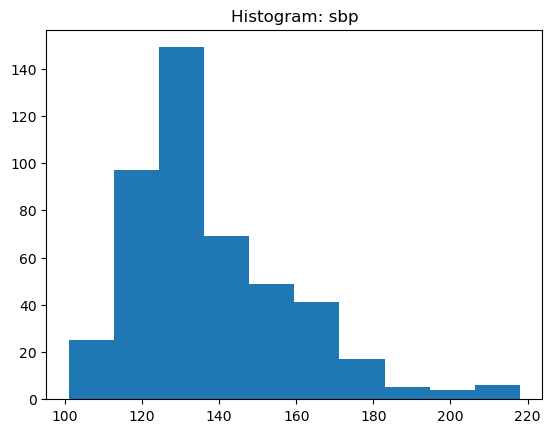

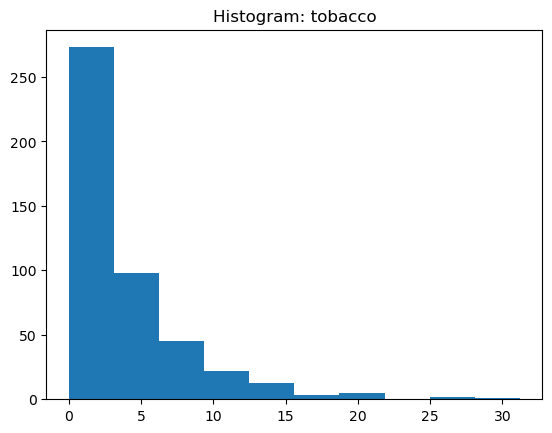

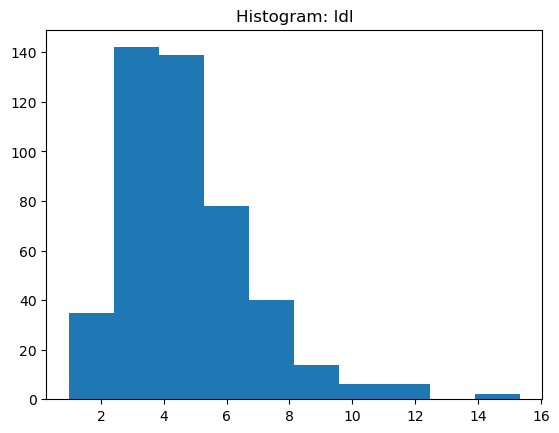

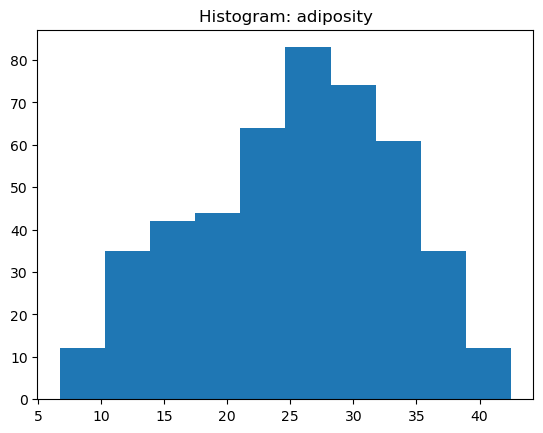

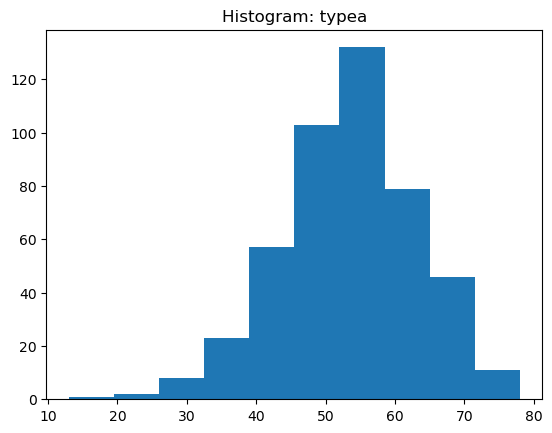

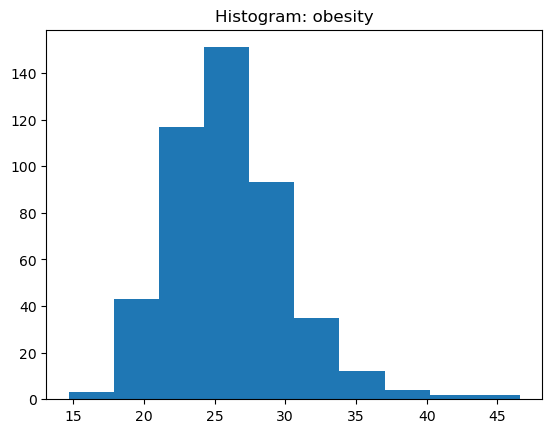

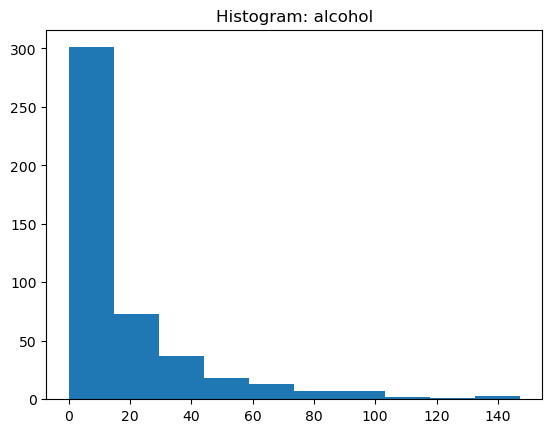

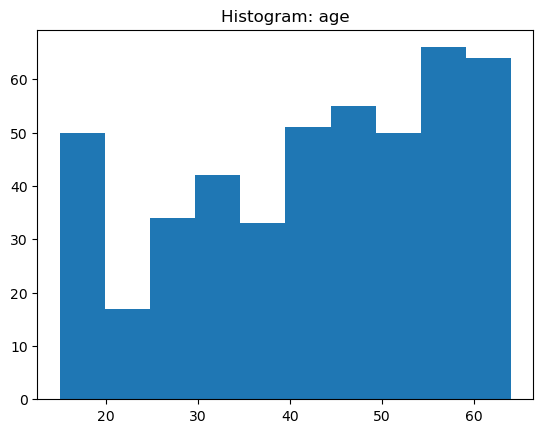

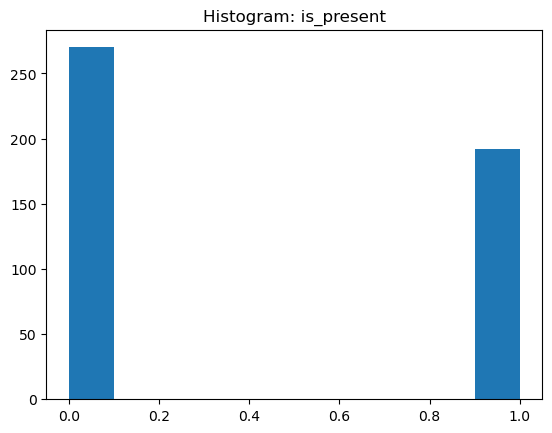

In [11]:
for i in column_names[:-1]:
    plt.hist(X[f"{i}"])
    plt.title(f"Histogram: {i}")
    plt.show()

### Fit of the Algorithm

In [74]:
iterations = 100000
proposal_std = 0.005
sample = metropolis_hastings_probit_single(Y_array, X_array, iterations, proposal_std)

In [76]:
final_effect = {}
for i in range(p):
    final_effect[column_names[i]] = sample[-1][i] 
final_effect

{'sbp': 0.0010837760628869763,
 'tobacco': 0.05967436633478397,
 'ldl': 0.09428210019777529,
 'adiposity': 0.046631115292647345,
 'typea': 0.02041621716923054,
 'obesity': -0.08828838704939686,
 'alcohol': -0.0024839995548308212,
 'age': 0.022344548847059033,
 'is_present': 0.39239578989369395,
 'intercept': -2.3824907757703877}

#### Correlation & Trace Plots

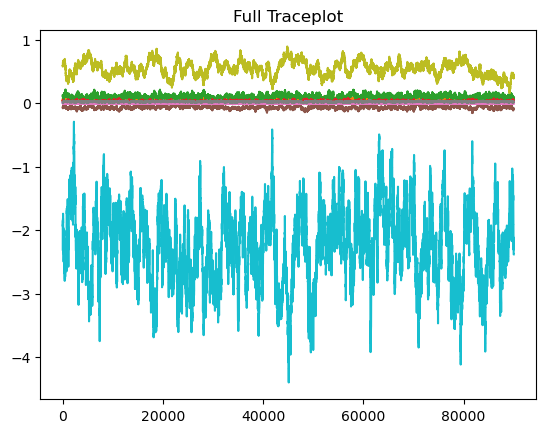

In [94]:
plt.plot(sample[10000:])
plt.title(f"Full Traceplot")
plt.show()

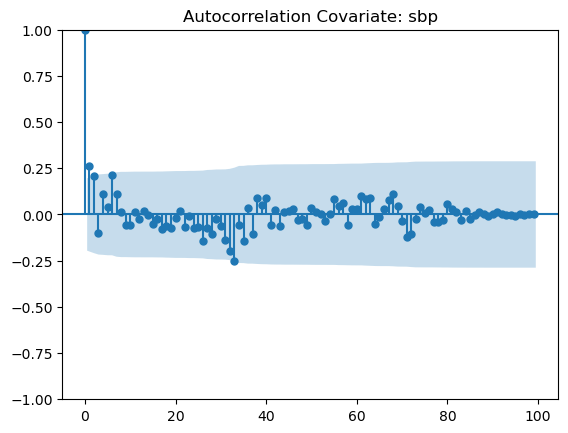

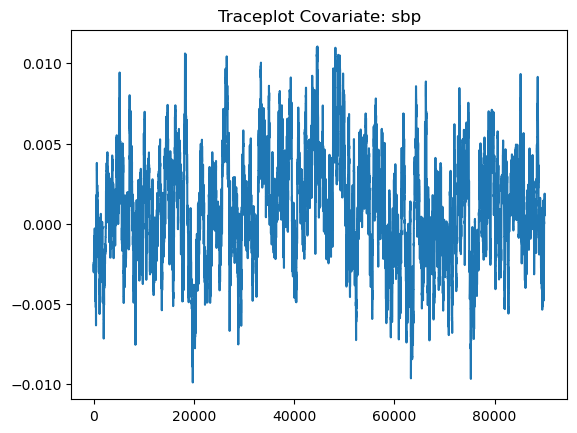

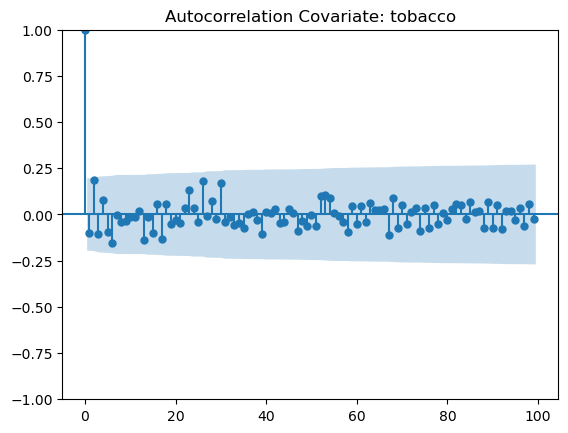

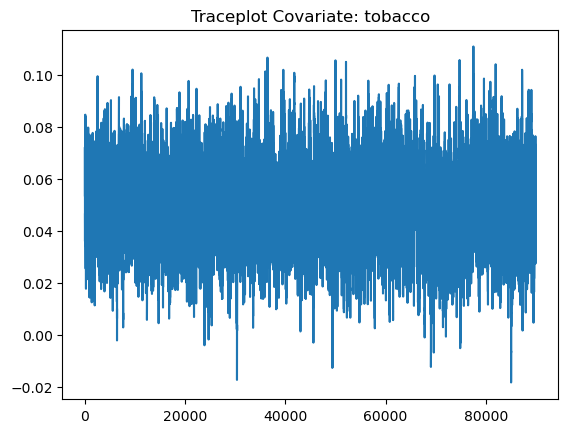

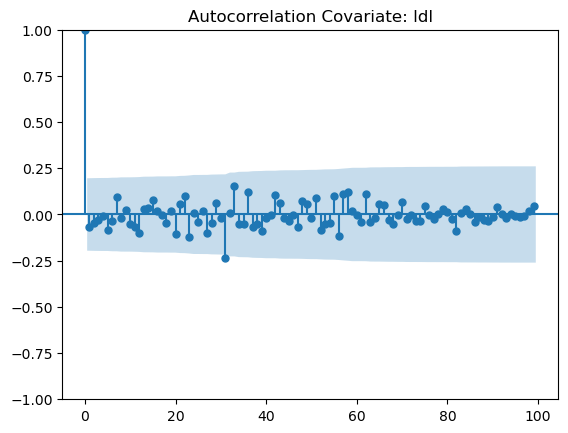

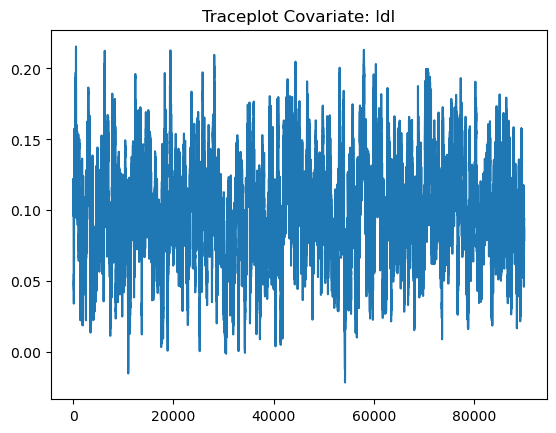

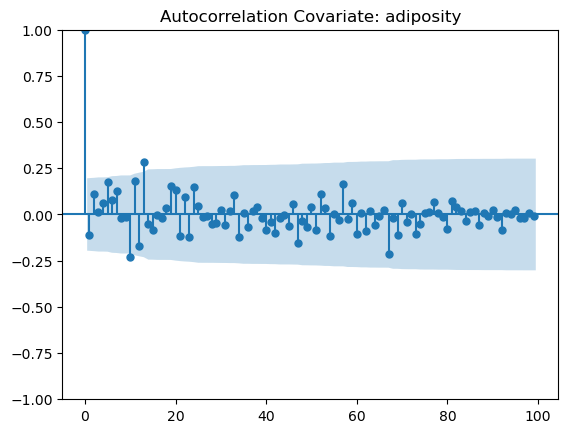

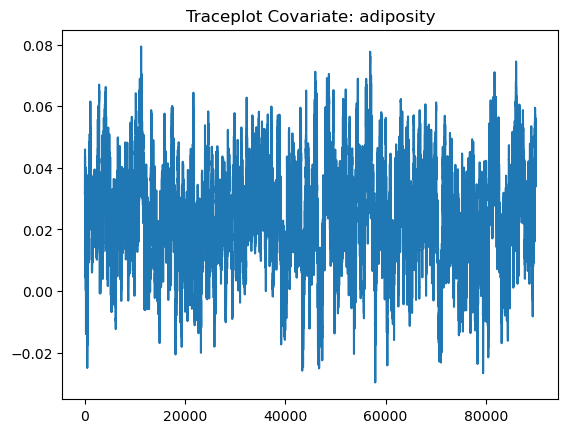

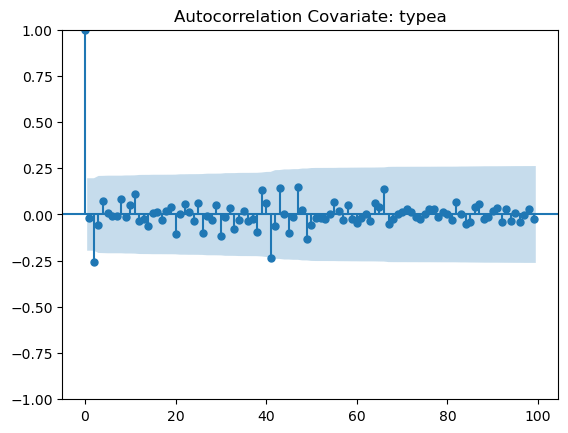

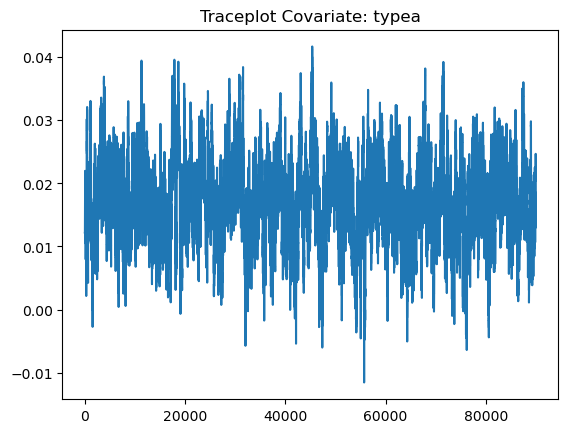

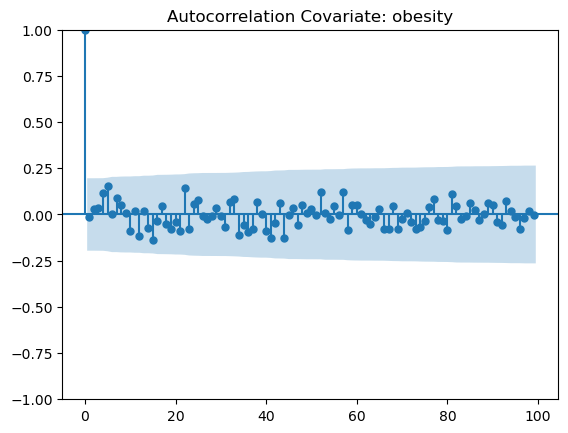

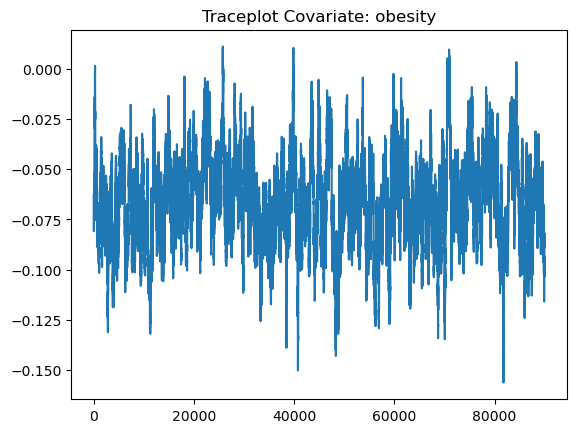

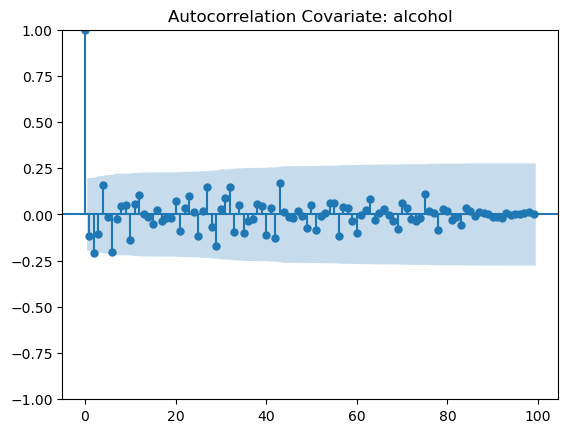

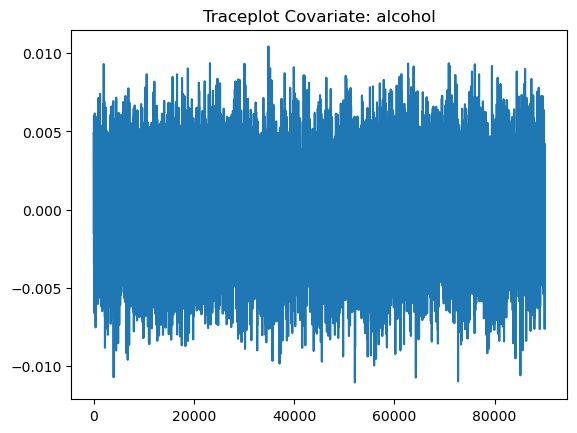

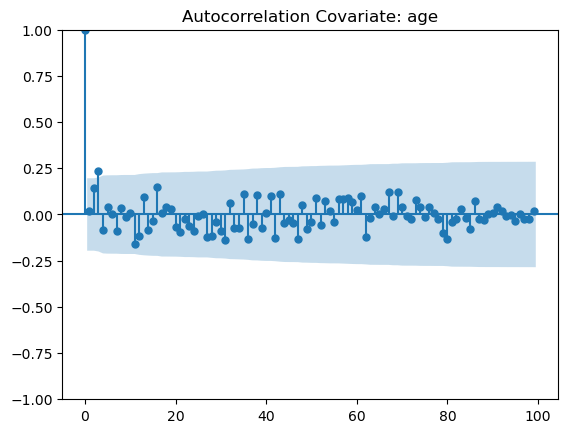

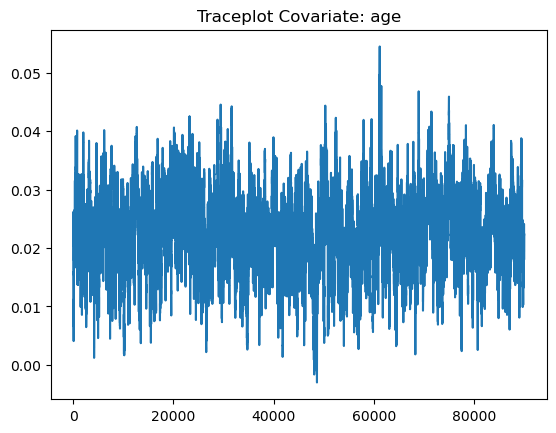

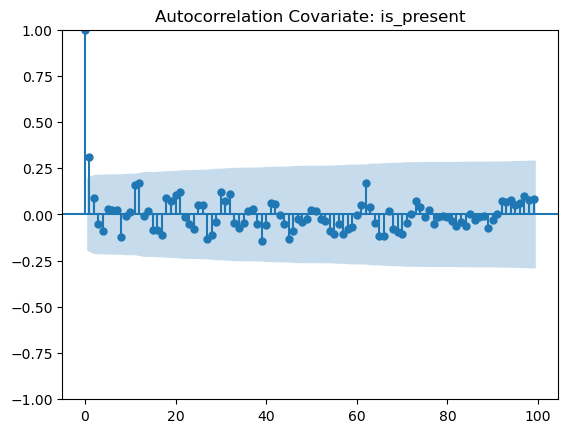

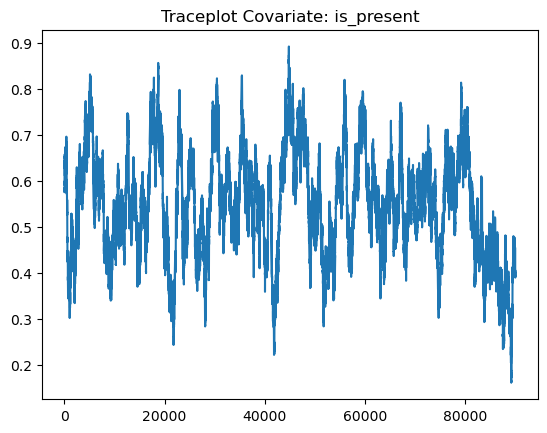

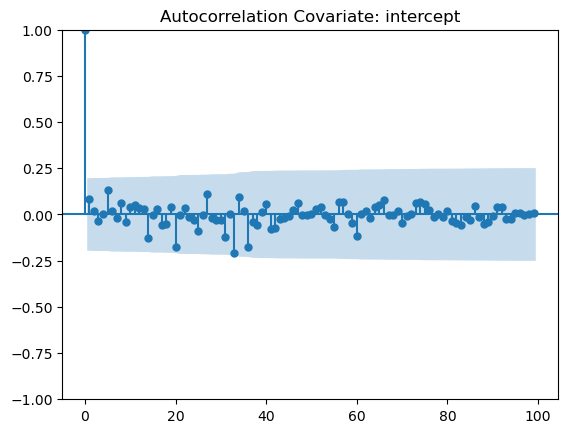

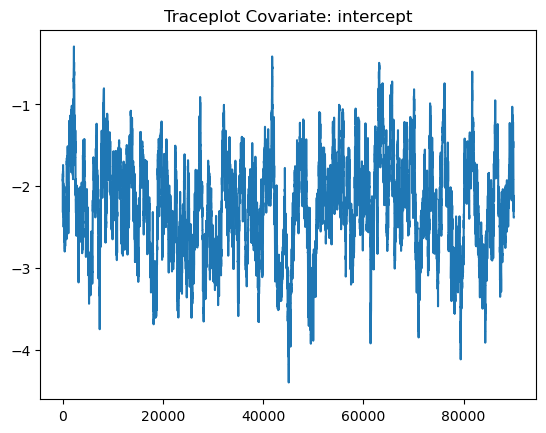

In [84]:
for i in range(p):
    thin_plot = sample[1:100000:1000, i]
    sm.graphics.tsa.plot_acf(thin_plot, lags=99, title=f"Autocorrelation Covariate: {column_names[i]}")
    plt.show()
    burnin_traceplot = sample[10000:, i]
    plt.plot(burnin_traceplot)
    plt.title(f"Traceplot Covariate: {column_names[i]}")
    plt.show()

### Marginal Effects

In [90]:
probitme_values = probit_ame(X_array, sample[-1])[:-1]
me_dict = {}
for i in range(p-1):
    me_dict[column_names[i]] = probitme_values[i] 
me_dict

{'sbp': 0.00030793740019435627,
 'tobacco': 0.016955503868971624,
 'ldl': 0.026788730452699097,
 'adiposity': 0.01324947551723017,
 'typea': 0.00580093716053209,
 'obesity': -0.025085714020037016,
 'alcohol': -0.0007057882077234168,
 'age': 0.006348841348414903,
 'is_present': 0.11149290293900514}